In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from theta.rtbm import RTBM
from theta.mathtools import normalization_consistency
import numpy as np
import copy
from cma import CMAEvolutionStrategy
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 4]

In [3]:
ndim = 1
nhid = 2
nevt = 1e4
rtbm = RTBM(ndim, nhid, 
            minimization_bound=50,
            gaussian_init=True,
            positive_T=True, 
            positive_Q=True,
            gaussian_parameters = {"mean" : 0, "std": 1.0},
            sampling_activation = "minmax"
           )
params_0 = copy.deepcopy(rtbm.get_parameters())

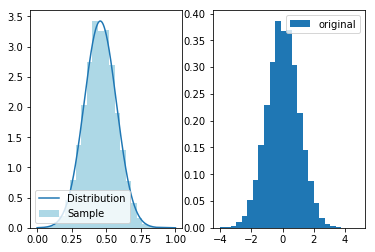

In [4]:
d = 0

def get_values():
    xrand, xjac, original_r = rtbm.make_sample_rho(nevt)

    x = []
    y = []
    ordered_r = []
    for i, j, k in sorted(zip(xrand[:,d], xjac, original_r)):
        x.append(i)
        y.append(j)
        ordered_r.append(k)

    x = np.array(x)
    y = np.array(y)
    ordered_r = np.array(ordered_r)
    return xrand, original_r, x, y, ordered_r

xrand, original_r, x, y, ordered_r = get_values()
        
plt.subplot(1,2,1)
plt.hist(xrand[:,d], bins=25, density=True, color="lightblue", label="Sample")
plt.plot(x, y, label="Distribution")
_ = plt.legend()
plt.subplot(1,2,2)
plt.hist(original_r[:,d], bins=25, density=True, label="original")
_ = plt.legend()

Total loss: 21588.7393574509


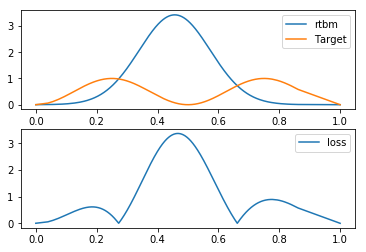

In [9]:
def my_fun(xarr):
    res = pow(np.sin(xarr*np.pi*2.0), 2)
    return res

def kl(x, y):
    return -(y*np.log(x))

def mse(x, y):
    return (x-y)**2

def labs(x,y):
    return np.abs(x-y)

loss = labs


my_y = my_fun(x)
_, y_rtbm = rtbm.get_transformation(ordered_r)
ll = loss(my_y, y_rtbm)

plt.subplot(2,1,1)
plt.plot(x, y_rtbm, label="rtbm")
plt.plot(x, my_y, label = "Target")
_ = plt.legend()
plt.subplot(2,1,2)
plt.plot(x, ll, label="loss")
_ = plt.legend()
print(f"Total loss: {np.sum(ll)}")

In [15]:
def target_loss(params):
    if not rtbm.set_parameters(params):
        return np.NaN
    _, prob = rtbm.get_transformation(ordered_r)
    return np.sum(loss(prob, my_y))

iterations = 3000
original_sigma = 0.15
sigma = original_sigma
epsilon = 1e-3
mutation_rates = np.array([0.2, 0.4, 0.6, 0.8])
population_per_rate = 128
rates = np.concatenate([np.ones(population_per_rate)*mr for mr in mutation_rates])
ss = len(params_0)

min_bound, max_bound = rtbm.get_bounds()
repeats = 3

from time import time

with Parallel(n_jobs=32) as parallel:
    
    best_parameters = params_0
    loss_val = target_loss(best_parameters)
    prev = time()
    
    for it in range(iterations):
        
        p0 = copy.deepcopy(best_parameters)
        
        def compute_mutant(mrate):
            nm = int(ss*mrate)
            mut_idx = np.random.choice(ss, nm, replace=False)
            r1, r2 = np.random.rand(2, nm)*sigma

            mutant = copy.deepcopy(p0)
            var_plus = max_bound - p0
            var_minus = min_bound - p0
            mutant[mut_idx] += var_plus[mut_idx]*r1 + var_minus[mut_idx]*r2
            
            return target_loss(mutant), mutant
    
        parallel_runs = [delayed(compute_mutant)(rate) for rate in rates]
        result = parallel(parallel_runs)
        losses, mutants = zip(*result)
        
        best_loss = np.nanmin(losses)
        if best_loss < loss_val:
            loss_val = best_loss
            best_parameters = mutants[losses.index(best_loss)]
        else:
            sigma /= 2
            
        if it % 50 == 0:
            current = time()
            print(f"Iteration: {it}, best loss: {loss_val:.2f}, time: {current-prev:.2f}s")
            prev = current
            
        if sigma < epsilon:
            print("Resetting sigma")
            sigma = original_sigma
            repeats -= 1
            
        if not repeats:
            print(f"No more repeats allowed, iteration: {it}, loss: {loss_val}")
            break
    rtbm.set_parameters(best_parameters)

Iteration: 0, best loss: 1751.47, time: 1.76s
Iteration: 50, best loss: 1144.23, time: 109.48s
Resetting sigma
Resetting sigma
Iteration: 100, best loss: 1100.74, time: 111.78s
Resetting sigma
No more repeats allowed, iteration: 116, loss: 1095.4975129821496


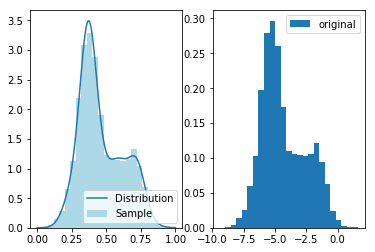

In [16]:
rtbm.set_parameters(best_parameters)
xrand_post, original_r_post, x_post, y_post, _ = get_values()

plt.subplot(1,2,1)
plt.hist(xrand_post[:,d], bins=25, density=True, color="lightblue", label="Sample")
plt.plot(x_post, y_post, label="Distribution")
_ = plt.legend()
plt.subplot(1,2,2)
plt.hist(original_r_post[:,d], bins=25, density=True, label="original")
_ = plt.legend()

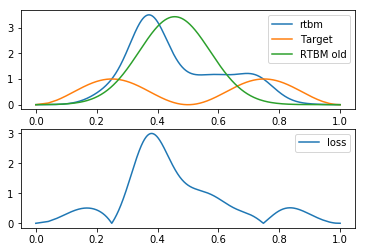

In [17]:
my_y_post = my_fun(x_post)
ll_post = loss(my_y_post, y_post)


plt.subplot(2,1,1)
plt.plot(x_post, y_post, label="rtbm")
plt.plot(x_post, my_y_post, label = "Target")
plt.plot(x, y, label="RTBM old")
_ = plt.legend()
plt.subplot(2,1,2)
plt.plot(x_post, ll_post, label="loss")
_ = plt.legend()
plt.savefig("nhid_3.png")

In [9]:
do_uniform = False
if do_uniform:
    rtbm.set_parameters(params_0)
    original_x_uniform = np.array(sorted(-1.0 + 2.0*np.random.rand(int(nevt),1)))
    x_uniform, y_uniform = rtbm.get_transformation(original_x_uniform)
    my_uniform = my_fun(x_uniform)

    plt.plot(x_uniform, y_uniform, label="rtbm")
    plt.plot(x_uniform, my_uniform, label = "Target")
    _ = plt.legend()

In [10]:
if do_uniform:
    batches = 1
    n_per_batch = int(len(original_x_uniform)/batches)
    
    i = 0
    
    xb = x_uniform[i*n_per_batch:(i+1)*n_per_batch]
    yb = y_uniform[i*n_per_batch:(i+1)*n_per_batch]
    myb = my_uniform[i*n_per_batch:(i+1)*n_per_batch]

    plt.plot(xb, yb, label="rtbm")
    plt.plot(xb, myb, label = "Target")
    _ = plt.legend()

In [11]:
if do_uniform:
    rtbm.set_parameters(params_0)
    with Parallel(n_jobs=32) as parallel:

        for _ in range(15):
            options = {
                "bounds": bounds,
                "maxiter": 20,
                "tolfun": 1e-4,
                "popsize": 180,
                "verbose": 0,
            }
            initial_state = copy.deepcopy(rtbm.get_parameters())
            es = CMAEvolutionStrategy(initial_state, sigma, options)

            i = np.random.randint(batches)
            xx = original_x_uniform[i*n_per_batch:(i+1)*n_per_batch]
            yy = my_uniform[i*n_per_batch:(i+1)*n_per_batch]

            def target_loss(params):
                if not rtbm.set_parameters(params):
                    return np.NaN
                    #import ipdb; ipdb.set_trace()
                _, prob = rtbm.get_transformation(xx)
                return np.sum(loss(prob, yy))

            while not es.stop():
                mutants = es.ask(es.popsize)
                # Parallelize this
                # losses = [target_loss(i) for i in mutants]
                parallel_runs = [delayed(target_loss)(i) for i in mutants]
                losses = parallel(parallel_runs)
                worst = np.nanmax(losses)
                if np.isnan(worst):
                    print("All NaN")
                    continue
                losses = [2.0*worst if np.isnan(x) else x for x in losses]
                es.tell(mutants, losses)
                es.disp()
        
        _ = rtbm.set_parameters(es.result.xbest)
    best_uniform_parameters = copy.deepcopy(rtbm.get_parameters())

In [12]:
if do_uniform:
    original_x_uniform = np.array(sorted(-1.0 + 2.0*np.random.rand(int(nevt),1)))
    x_uniform, y_uniform = rtbm.get_transformation(original_x_uniform)
    my_uniform = my_fun(x_uniform)
    ll_uniform = loss(y_uniform, my_uniform) 

    plt.subplot(2,1,1)
    plt.plot(x_uniform, y_uniform, label="rtbm")
    plt.plot(x_uniform, my_uniform, label = "Target")
    _ = plt.legend()
    plt.subplot(2,1,2)
    plt.plot(x_uniform, ll_post, label="loss")
    _ = plt.legend()